 **Quora Insincere Questions Classification** 




**Build a model for predicting whether a question asked on Quora is sincere or not.**

In [ ]:
# Import all required libraries 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np

In [ ]:
#Loading test and train datasets
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv("test.csv")

In [ ]:
  df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
  df_train.shape

(1306122, 3)

In [ ]:
df_train.dtypes.value_counts()


object    2
int64     1
dtype: int64

In [ ]:
# Number of words in question
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))


In [ ]:
# number of numerics
df_train['num_numerics'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['num_numerics'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))


In [ ]:
# Length of questions 
df_train['qlen'] = df_train['question_text'].str.len()
df_test['qlen'] = df_test['question_text'].str.len() 

In [ ]:
df_train.head(2)

,qid,question_text,target,num_words,num_numerics,qlen
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,4,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,0,81


In [ ]:
df_test.head(2)

,qid,question_text,num_words,num_numerics,qlen
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,21,0,101
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,30,0,162


**Exploratory data analysis**

In [ ]:
# Chencking null values in test and train datasets 
df_train.isnull().values.any(),    df_test.isnull().values.any()

(False, False)

In [ ]:
len(df_train['qid'].unique())

1306122

In [ ]:
# Target column analysis 
df_train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


% of 1 in train data: 6.187017751787352


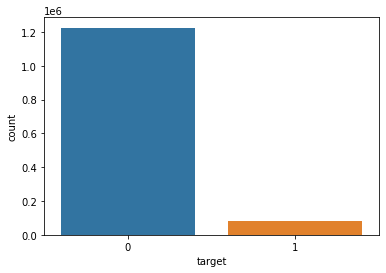

In [ ]:
import seaborn as sns
sns.countplot(df_train.target)
print('% of 1 in train data:', (df_train.target.value_counts()[1]/df_train.shape[0]) * 100)

Most used words in sincere questions: 


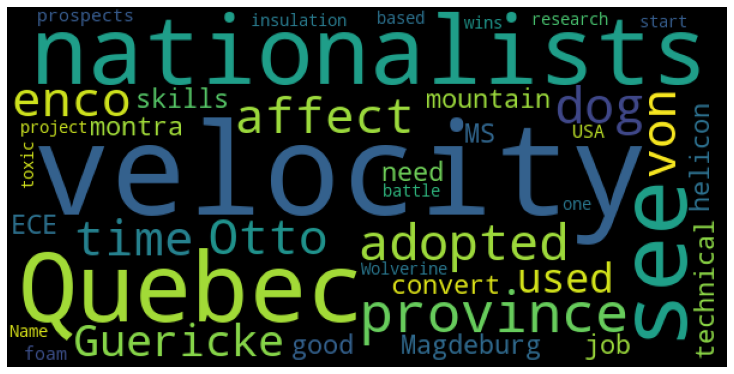

In [ ]:
from wordcloud import WordCloud
print("Most used words in sincere questions: ")
sincere_wordcloud = WordCloud(width=600, height=300, background_color='black', min_font_size=10).generate(str(df_train[df_train["target"] == 0]["question_text"]))
plt.figure(figsize=(10,9), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


Most used words in insincere questions: 


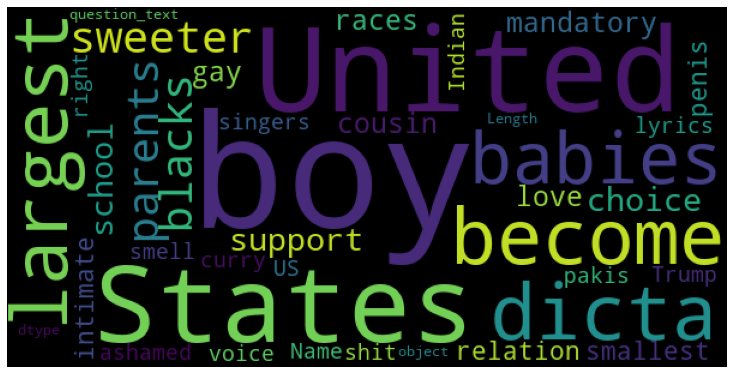

In [ ]:
print("Most used words in insincere questions: ")
insincere_wordcloud = WordCloud(width=600, height=300, background_color='black', min_font_size=10).generate(str(df_train[df_train["target"] == 1]["question_text"]))
plt.figure(figsize=(10,9), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
new_train=df_train.drop(['qid','question_text'], axis=1)
new_train.head(2)

,target,num_words,num_numerics,qlen
0,0,13,4,72
1,0,16,0,81


0    1225312
1      80810
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE over-sampling:
1    1225312
0    1225312
Name: target, dtype: int64


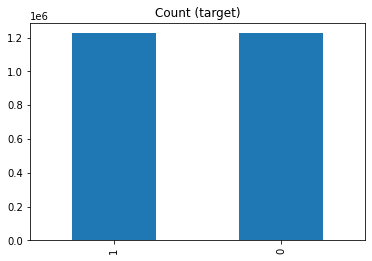

In [ ]:
# Using SMOTE for balancing the target column in train dataset

from imblearn.over_sampling import SMOTE

print(new_train.target.value_counts())

X = new_train.drop('target', axis=1)
Y = new_train['target']

sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)

df_smote_over = pd.concat([pd.DataFrame(X_res), pd.DataFrame(Y_res, columns=['target'])], axis=1)

print('SMOTE over-sampling:')
print(df_smote_over.target.value_counts())

df_smote_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
#Outliers
#As the data is huge, we will first calculate the z-score of the training data
from scipy import stats

# Dropping ID and target columns
z_score_calc = df_train.drop(columns=['qid', 'question_text'])
# Calculating z score
z = np.abs(stats.zscore(z_score_calc))
# print(z)
threshold = 3
print(np.where(z > 4))

(array([      9,       9,      33, ..., 1306102, 1306109, 1306109]), array([1, 3, 2, ..., 3, 1, 3]))


In [ ]:
treated_data = df_train[(z < 4).all(axis=1)]
print("before treating outliers : {}".format(df_train.shape))
print("after treating outliers : {}".format(treated_data.shape))

before treating outliers : (1306122, 6)
after treating outliers : (1275357, 6)


There are total 30765 outliers rows that are removed



In [ ]:
from sklearn.utils import resample
sincere = df_train[df_train.target == 0]
insincere = df_train[df_train.target == 1]
df_train_sampled = pd.concat([resample(sincere,replace = True,n_samples = len(insincere)*4), insincere])

In [ ]:
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

wordnet_lemmatizer = WordNetLemmatizer()
import re, string
tokenizer = ToktokTokenizer()
stemmer = SnowballStemmer('english')
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Text cleaning 

def clean_text(text):

    # Removing HTML Tags
    text = re.sub(re.compile('<.*?>'), '', text)

    # Removing  [\], ['], ["]
    text = re.sub(r'\\', '', text)
    text = re.sub(r'\"', '', text)
    text = re.sub(r'\'', '', text)

    text = re.sub('[0-9]{5,}','#####', text);
    text = re.sub('[0-9]{4,}','####', text);
    text = re.sub('[0-9]{3,}','###', text);
    text = re.sub('[0-9]{2,}','##', text);

    roman = re.compile(r'^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$');
    text = roman.sub(r'', text);

    #
    text = text.strip().lower()

    filters = '!"\'#$%@&*()+_-;:<=>.?{}|`\\^\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    #token 
    #tokens = tokenizer.tokenize(text)
    #tokens = [token.strip() for token in tokens]
    #tokens = [token for token in tokens if token not in stop_words]
    #tokens = [stemmer.stem(token) for token in tokens]
    #tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    
    return text

In [ ]:
df_train_sampled['preprocessed_questions'] = df_train_sampled['question_text'].apply(clean_text)

In [ ]:
df_train_sampled.head()

,qid,question_text,target,num_words,num_numerics,qlen,preprocessed_questions
84572,108f3fe9064560bac6e9,What are the elementary particles which form t...,0,9,0,56,what are the elementary particles which form t...
325131,3fb946501b9596819127,Why can't I delete a post I've made on Quora?,0,10,0,45,why cant i delete a post ive made on quora
893182,aeff771a7e5a49ac70b3,Non-partisan Congressional Budget Office said ...,0,21,2,147,non partisan congressional budget office said ...
1165320,e4597c61f47df2bb8079,Do athletic girls who workout prefer a big mus...,0,20,0,106,do athletic girls who workout prefer a big mus...
653533,8002ff669e3c1a69f29c,Why do I respect all religions?,0,6,0,31,why do i respect all religions


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

X = df_train_sampled['preprocessed_questions']
y = df_train_sampled.target

test = df_test['question_text']
X_train, X_test, y_train, y_test = train_test_split(df_train_sampled['preprocessed_questions'], df_train_sampled['target'], test_size=0.3)

In [ ]:
cnt_vectorizer = CountVectorizer()
cnt_vectorizer.fit(list(X_train) + list(X_test))

X_train = cnt_vectorizer.transform(X_train) 
X_test = cnt_vectorizer.transform(X_test)
df_train_sampled["preprocessed_questions"].head()

84572      what are the elementary particles which form t...
325131           why cant i delete a post ive made on quora 
893182     non partisan congressional budget office said ...
1165320    do athletic girls who workout prefer a big mus...
653533                       why do i respect all religions 
Name: preprocessed_questions, dtype: object

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fitting a simple Logistic Regression
logisticRegression = LogisticRegression(max_iter = 5000)
logisticRegression.fit(X_train,y_train)

test_predictions = logisticRegression.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions) 
test_f1 = f1_score(y_test, test_predictions) 

print(f"Testing accuracy:  {test_acc:.2%}, F1: {test_f1:.4f}")

Testing accuracy:  91.10%, F1: 0.7609


In [ ]:
x_val = cnt_vectorizer.transform(df_test['question_text'])
validation_predictions = logisticRegression.predict(x_val)
submission = pd.DataFrame({'qid':df_test['qid'], 'prediction':validation_predictions })
submission.to_csv('submission.csv', index=False)
submission


,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     97018
           1       0.82      0.71      0.76     24197

    accuracy                           0.91    121215
   macro avg       0.88      0.84      0.85    121215
weighted avg       0.91      0.91      0.91    121215

